# Part 1:- JPEG Compression

Including libraries

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

Input:- Filename, Block Size, # of Coefficient parameters sent, Color/grayscale binary input

In [2]:
image = 'Images/kodim23.png'
blockSize = 8
noOfcoeffParameters = 64
codefile = 'encoding.txt'
color = 1

Initialising Quantization Matrix

In [3]:
def quantizationMat(blockSz):
    Q_Y = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                   [12, 12, 14, 19, 26, 58, 60, 55],
                   [14, 13, 16, 24, 40, 57, 69, 56],
                   [14, 17, 22, 29, 51, 87, 80, 62],
                   [18, 22, 37, 56, 68, 109, 103, 77],
                   [24, 35, 55, 64, 81, 104, 113, 92],
                   [49, 64, 78, 87, 103, 121, 120, 101],
                   [72, 92, 95, 98, 112, 100, 103, 99]], dtype=np.uint8)

    Q_C = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                   [18, 21, 26, 66, 99, 99, 99, 99],
                   [24, 26, 56, 99, 99, 99, 99, 99],
                   [47, 66, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99]], dtype=np.uint8)


    if(blockSize != Q_Y.shape[0]):
        Q_Y = cv.resize(Q_Y, (blockSize, blockSize))
        Q_C = cv.resize(Q_C, (blockSize, blockSize))
        
    return Q_Y, Q_C

Function to show image

In [4]:
def cvShow(img):
    b,g,r = cv.split(img)
    opimg = cv.merge([r, g, b])
    
    plt.imshow(opimg)

Converting rgb image to Yuv

In [5]:
def convertToYuv(img):
    imgYuv = cv.cvtColor(img, cv.COLOR_RGB2YUV)
    return imgYuv

Add Padding

In [6]:
def addPadding(img, blockSize, color):
    h, w = img.shape[0], img.shape[1]

    new_w, new_h = 0, 0

    if(w % blockSize != 0):
        r1 = w % blockSize
        new_w = blockSize - r1

    if(h % blockSize != 0):
        r2 = h % blockSize
        new_h = blockSize - r2

    if(color == 1):
        newImg = np.zeros((new_h + h, new_w + w, 3), dtype=np.float32)
        for i in range(h):
            for j in range(w):
                for k in range(3):
                    newImg[i, j, k] = int(img[i, j, k])
    else:
        newImg = np.zeros((new_h + h, new_w + w), dtype=np.float32)
        for i in range(h):
            for j in range(w):
                newImg[i, j] = int(img[i, j])
    
    return newImg

Subtract 128

In [7]:
def subtract128(img, color):
    h, w = img.shape[0], img.shape[1]
    
    if(color == 1):
        for i in range(h):
            for j in range(w):
                for k in range(3):
                    img[i, j, k] = img[i, j, k] - 128
    else:
        for i in range(h):
            for j in range(w):
                img[i, j] = img[i, j] - 128
    
    return img

Block Division

In [8]:
def applyDCT(newImg, blockSize, color):
    i = 0
    if(color == 1):
        while(i < newImg.shape[0]):
            j = 0
            while(j < newImg.shape[1]):
                for k in range(3):
                    block = newImg[i : i + blockSize, j : j + blockSize, k]
                    block = cv.dct(np.float32(block))
                    newImg[i : i + blockSize, j : j + blockSize, k] = block
                j = j + blockSize

            i = i + blockSize
            if(i >= newImg.shape[0]):
                break
    else:
        while(i < newImg.shape[0]):
            j = 0
            while(j < newImg.shape[1]):
                block = newImg[i : i + blockSize, j : j + blockSize]
                block = cv.dct(np.float32(block))
                newImg[i : i + blockSize, j : j + blockSize] = block
                j = j + blockSize

            i = i + blockSize
            if(i >= newImg.shape[0]):
                break
    
    return newImg

Division by Quantization matrix

In [9]:
def doQuantization(newImg, blockSize, color):

    blocks = int(newImg.shape[0] / blockSize)
    blocks

    Q_Y, Q_C = quantizationMat(blockSize)

    i = 0
    if(color == 1):
        while(i < newImg.shape[0]):
            j = 0
            while(j < newImg.shape[1]):
                for k in range(3):
                    block = newImg[i : i + blockSize, j : j + blockSize, k]

                    for s in range(0, blockSize):
                        for t in range(0, blockSize):
                            if(k == 0):
                                block[s, t] = np.round(block[s, t] / Q_Y[s, t]).astype('float32')
                            else:
                                block[s, t] = np.round(block[s, t] / Q_C[s, t]).astype('float32')

                    newImg[i : i + blockSize, j : j + blockSize, k] = block
                j = j + blockSize

            i = i + blockSize
            if(i >= newImg.shape[1]):
                break
    else:
        while(i < newImg.shape[0]):
            j = 0
            while(j < newImg.shape[1]):
                block = newImg[i : i + blockSize, j : j + blockSize]

                for s in range(0, blockSize):
                    for t in range(0, blockSize):
                        block[s, t] = np.round(block[s, t] / Q_Y[s, t]).astype('float32')

                newImg[i : i + blockSize, j : j + blockSize] = block
                j = j + blockSize

            i = i + blockSize
            if(i >= newImg.shape[1]):
                break
    
    return newImg

Find ZigZig Pattern

In [10]:
def findZigZag(img):
    movement = 1
    
    components = []
    
    i = 0
    j = 0

    h, w = img.shape

    while((i >= 0 and i < h) or (j >= 0 and j < w)):
        components.append(img[i, j])

        if(i == h - 1 and j == w - 1):
            break

        if(movement == 1):
            if(i - 1 >= 0 and j + 1 < w):
                i = i - 1
                j = j + 1
            elif(j + 1 < w):
                j = j + 1
                movement = 0
            else:
                i = i + 1
                movement = 0
        else:
            if(i + 1 < h and j - 1 >= 0):
                i = i + 1
                j = j - 1
            elif(i + 1 < h):
                i = i + 1
                movement = 1
            else:
                j = j + 1
                movement = 1
    
    return components

Find DC components

In [11]:
def findDCcomponents(img, coeffPara, blocksize, filename, color):
    
    dcComponents = []
    i = 0    
    if(color == 1):
        with open(filename, 'w') as f:
            while i < img.shape[0]:
                j = 0
                while(j < img.shape[1]):
                    blockComponents = []

                    for k in range(3):
                        block = img[i : i + blockSize, j : j + blockSize, k]
                        channelComponents = []
                        channelComponents = findZigZag(block)
                        channelComponents = channelComponents[:coeffPara]
                        blockComponents.append(channelComponents)

                    dcComponents.append(blockComponents)
                    f.write(str(blockComponents) + '\n')
                    j = j + blockSize

                i = i + blockSize
                if(i >= img.shape[0]):
                    return dcComponents
    else:
        with open(filename, 'w') as f:
            while i < img.shape[0]:
                j = 0
                while(j < img.shape[1]):
                    blockComponents = []
                    block = img[i : i + blockSize, j : j + blockSize]
                    blockComponents = findZigZag(block)
                    blockComponents = blockComponents[:coeffPara]
                    dcComponents.append(blockComponents)
                    f.write(str(blockComponents) + '\n')
                    j = j + blockSize

                i = i + blockSize
                if(i >= img.shape[0]):
                    return dcComponents

In [12]:
def jpegEncoder(imgfile, blockSize, coeffPara, codefile, color):
    img = cv.imread(imgfile)
    
    if(color == 0):
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    if(color == 1):
        imgYuv = convertToYuv(img)
    else:
        imgYuv = img
    
    newImg = addPadding(imgYuv, blockSize, color)
    newImg = subtract128(newImg, color)
    newImg = applyDCT(newImg, blockSize, color)
    newImg = doQuantization(newImg, blockSize, color)
    dcComponents = findDCcomponents(newImg, coeffPara, blockSize, codefile, color)
    return dcComponents

Decoding

In [13]:
def fillZigZag(img, dcComp, blockNo, chNo, coeffPara):
    movement = 1
    
    i = 0
    j = 0
    c = 0

    h, w = img.shape

    while((i >= 0 and i < h) or (j >= 0 and j < w)):
        img[i, j] = dcComp[blockNo][chNo][c]
        
        c = c + 1
        if(c == coeffPara):
            break

        if(i == h - 1 and j == w - 1):
            break

        if(movement == 1):
            if(i - 1 >= 0 and j + 1 < w):
                i = i - 1
                j = j + 1
            elif(j + 1 < w):
                j = j + 1
                movement = 0
            else:
                i = i + 1
                movement = 0
        else:
            if(i + 1 < h and j - 1 >= 0):
                i = i + 1
                j = j - 1
            elif(i + 1 < h):
                i = i + 1
                movement = 1
            else:
                j = j + 1
                movement = 1
    
    return img

In [14]:
def fillZigZagGray(img, dcComp, blockNo, coeffPara):
    movement = 1
    
    i = 0
    j = 0
    c = 0

    h, w = img.shape

    while((i >= 0 and i < h) or (j >= 0 and j < w)):
        img[i, j] = dcComp[blockNo][c]
        
        c = c + 1
        if(c == coeffPara):
            break

        if(i == h - 1 and j == w - 1):
            break

        if(movement == 1):
            if(i - 1 >= 0 and j + 1 < w):
                i = i - 1
                j = j + 1
            elif(j + 1 < w):
                j = j + 1
                movement = 0
            else:
                i = i + 1
                movement = 0
        else:
            if(i + 1 < h and j - 1 >= 0):
                i = i + 1
                j = j - 1
            elif(i + 1 < h):
                i = i + 1
                movement = 1
            else:
                j = j + 1
                movement = 1
    
    return img

In [15]:
def jpegDecoder(imagename, blockSize, dcComponents, coeffParameters, color):
    img = cv.imread(imagename)
    
    if(color == 0):
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
    output = np.zeros_like(img, dtype=np.float32)
    output = addPadding(output, blockSize, color)
#     print(output.shape)

    i = 0
    blockctr = 0
    if(color == 1):
        while(i < output.shape[0]):
            j = 0
            while(j < output.shape[1]):
                for k in range(3):
                    #filling zigzig values
                    block = output[i : i + blockSize, j : j + blockSize, k]
                    block = fillZigZag(block, dcComponents, blockctr, k, coeffParameters)

                    Q_Y, Q_C = quantizationMat(blockSize)

                    #multiplying by q
                    if(k == 0):
                        block = np.multiply(block, Q_Y)
                    else:
                        block = np.multiply(block, Q_C)

                    #finding inversedct
                    block = cv.idct(block)

                    #add 128
                    block = block + 128

                    block = block.astype(np.int32)

                    output[i : i + blockSize, j : j + blockSize, k] = block
                j = j + blockSize
                blockctr = blockctr + 1

            i = i + blockSize
            if(i >= output.shape[1]):
                output = output.astype(np.uint8)
                output = cv.cvtColor(output, cv.COLOR_YUV2RGB)
                break
    else:
        while(i < output.shape[0]):
            j = 0
            while(j < output.shape[1]):
                #filling zigzig values
                block = output[i : i + blockSize, j : j + blockSize]
                block = fillZigZagGray(block, dcComponents, blockctr, coeffParameters)

                Q_Y, Q_C = quantizationMat(blockSize)

                #multiplying by q
                block = np.multiply(block, Q_Y)

                #finding inversedct
                block = cv.idct(block)

                #add 128
                block = block + 128

                block = block.astype(np.int32)

                output[i : i + blockSize, j : j + blockSize] = block
                j = j + blockSize
                blockctr = blockctr + 1

            i = i + blockSize
            if(i >= output.shape[1]):
                output = output.astype('uint8')
                break
    
    img = addPadding(img, blockSize, color)
    psnrr = PSNR(img, output)
    rmsee = RMSE(img, output)
    cr = compressionRatio(img, blockSize, coeffParameters, color)
    
    print(f"Root Mean Square Error: {rmsee}")
    print(f"PSNR: {psnrr}")
    print(f"Compression Ratio: {cr}")
    return output

In [16]:
def PSNR(origImg, opImg):
    sub = np.subtract(origImg, opImg)
    sq = np.square(sub)
    mean = np.mean(sq)
    
    max_pixel = 255.0
    ans = 10 * np.log10((max_pixel ** 2) / mean)
    return ans

In [17]:
def RMSE(origImg, opImg):
    sub = np.subtract(origImg, opImg)
    sq = np.square(sub)
    mean = np.mean(sq)
    ans = np.sqrt(mean)
    
    return ans

In [18]:
def compressionRatio(origImg, blockSize, coeffPara, color):
    if(color == 1):
        h, w, c = origImg.shape
        trueV = h * w * c
        compr = ((h * w) // (blockSize * blockSize)) * c * coeffPara
        return trueV / compr
    else:
        h, w = origImg.shape
        trueV = h * w
        compr = ((h * w) // (blockSize * blockSize)) * coeffPara
        return trueV / compr

# ENCODE HERE

In [19]:
dcc = jpegEncoder(image, blockSize, noOfcoeffParameters, codefile, color)

# DECODE HERE

Root Mean Square Error: 60.51070785522461
PSNR: 12.494158783657634
Compression Ratio: 1.0


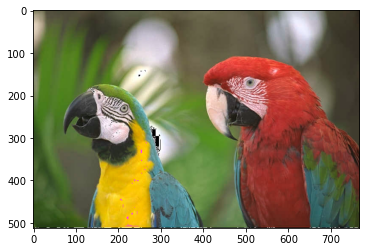

In [20]:
outputImg = jpegDecoder(image, blockSize, dcc, noOfcoeffParameters, color)
outputImg = outputImg.astype(np.uint8)
if(color == 1):
    outputImg = cv.cvtColor(outputImg, cv.COLOR_YUV2RGB)
    cvShow(outputImg)
else:
    plt.imshow(outputImg, cmap='gray')